# 원리

1. n_cluster개의 cluster center를 초기화
2. 각 데이터 포인트를 가장 가까운 cluster center에 할당
3. 할당한 포인트의 평균값으로 cluster center 갱신
4. 변화가 없을 때까지 2~3 반복

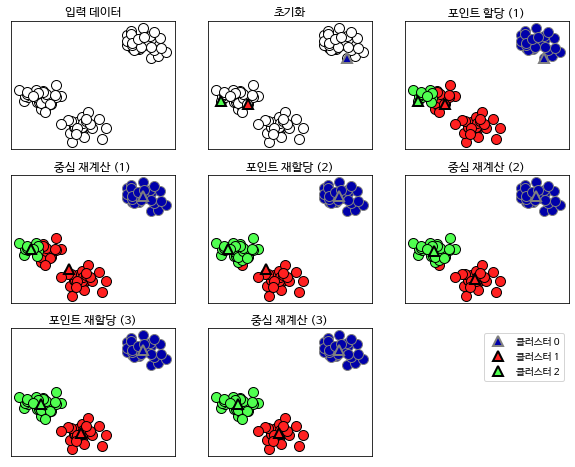

In [1]:
from ml1.preamble import*
mglearn.plots.plot_kmeans_algorithm()

5. 새로운 포인트가 주어지면 가장 가까운 cluster center에 해당하는 값을 할당

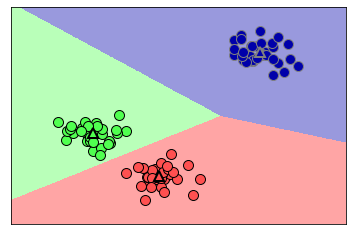

In [2]:
mglearn.plots.plot_kmeans_boundaries()

# 코드

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(random_state=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

print('클러스터 레이블 :\n', kmeans.labels_)

클러스터 레이블 :
 [0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 2 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


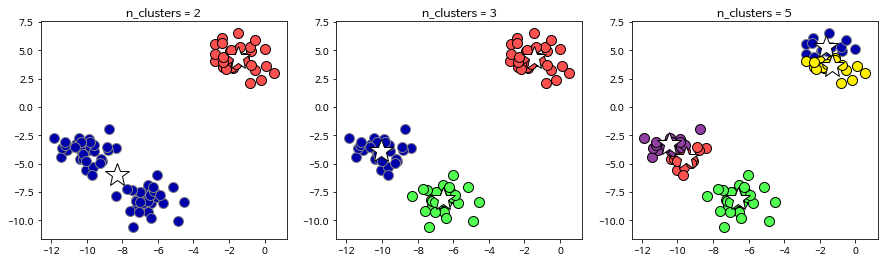

In [4]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, n_clusters in zip(axes,[2,3,5]):
    kmeans = KMeans(n_clusters = n_clusters).fit(X)
    ax.set_title(f'n_clusters = {n_clusters}')
    mglearn.discrete_scatter(X[:,0], X[:,1], kmeans.labels_, markers='o', ax=ax)
    mglearn.discrete_scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='w', s=25,
                         markers='*', ax=ax)

# KMeans가 적절하지 않은 경우

## 클러스터의 밀도가 다를 때

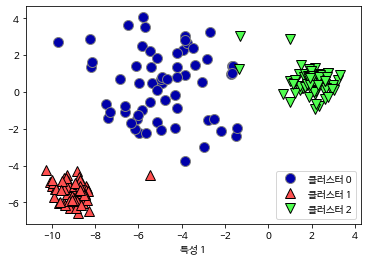

In [5]:
X, y = make_blobs(n_samples=200, cluster_std=[0.5, 2, 0.5], random_state=170)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

mglearn.discrete_scatter(X[:,0], X[:,1], kmeans.labels_)
plt.legend(['클러스터 0', '클러스터 1', '클러스터 2'], loc='best')
plt.xlabel('특성 0')
plt.xlabel('특성 1')
plt.show()

=> KMeans는 모든 클러스터의 반경이 똑같다고 가정하므로 적절하지 않음

## 클러스터가 원형이 아닐 때

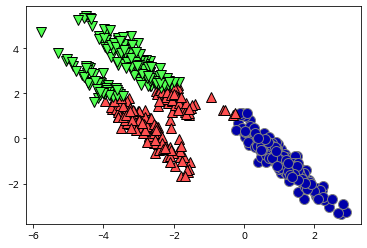

In [6]:
X, y = make_blobs(random_state=170, n_samples=600)
transform = np.random.RandomState(74).normal(size=(2,2))
X = np.dot(X, transform)

kmeans = KMeans(n_clusters=3).fit(X)

mglearn.discrete_scatter(X[:,0], X[:,1], kmeans.labels_)
plt.show()

=> KMeans는 cluster를 둥근 원으로 가정하므로 적절하지 못함<br>

## 복잡한 형태의 클러스터일 때

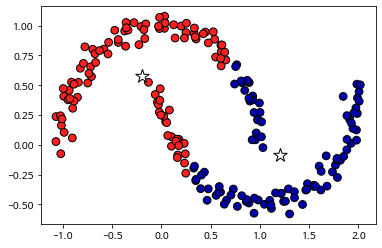

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise =0.05, random_state=0)

kmeans = KMeans(n_clusters=2).fit(X)

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap=mglearn.cm2, s=60, edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*', c='w', s=200, edgecolors='k')

# 벡터 양자화

## PCA, NMF와 비교

* PCA와 NMF은 데이터 포인트를 어떤 성분들의 합으로 표현함
* 반면에 KMean은 각 데이터 포인트를 cluster_center 하나의 성분으로 볼 수 있음

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

#얼굴 데이터 
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
image_shape= people.images[0].shape
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people, y_people = people.data[mask]/255, people.target[mask]
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify= y_people, random_state=42)

# 모델 생성
from sklearn.decomposition import PCA, NMF
nmf = NMF(n_components=100, max_iter=1000, tol=1e-2, random_state=0).fit(X_train)
pca = PCA(n_components=100, random_state=0).fit(X_train)
kmeans = KMeans(n_clusters=100, random_state=0).fit(X_train)

* 성분 확인

Text(0, 0.5, 'nmf')

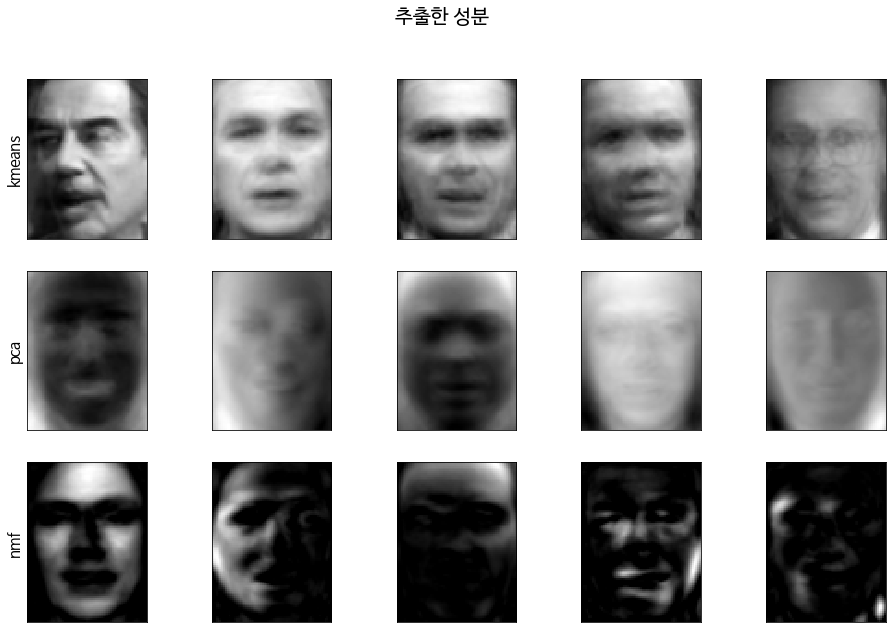

In [9]:
fig, axes = plt.subplots(3,5, figsize=(16,10), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle('추출한 성분', fontsize=20)
for ax, comp_kmeans, comp_pca, comp_nmf in zip(axes.T, kmeans.cluster_centers_, pca.components_, nmf.components_):
    ax[0].imshow(comp_kmeans.reshape(image_shape), cmap='gray')
    ax[1].imshow(comp_pca.reshape(image_shape), cmap='gray')
    ax[2].imshow(comp_nmf.reshape(image_shape), cmap='gray')
axes[0, 0].set_ylabel("kmeans", fontsize=15)
axes[1, 0].set_ylabel("pca", fontsize=15)
axes[2, 0].set_ylabel("nmf", fontsize=15)

* 재구성

Text(0, 0.5, 'nmf')

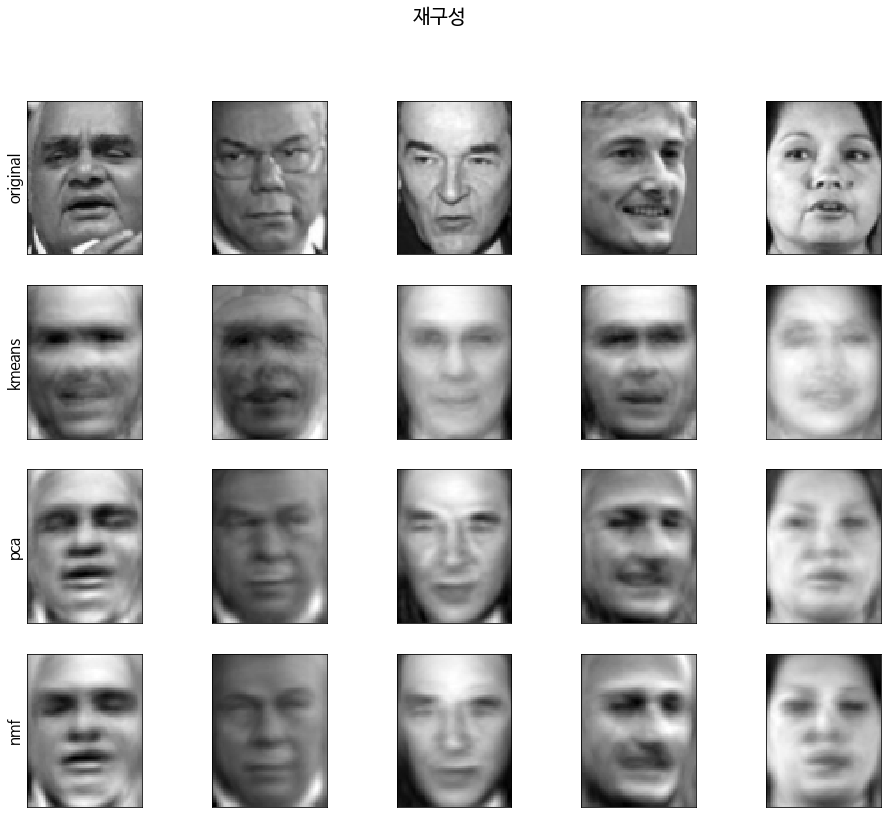

In [10]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(X_test)]
X_reconstructed_nmf = nmf.inverse_transform(nmf.transform(X_test))

fig, axes = plt.subplots(4,5, figsize=(16,13), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle('재구성', fontsize=20)
for ax, orig, rec_kmeans, rec_pca, rec_nmf in zip(axes.T, X_test, X_reconstructed_kmeans,
                                                  X_reconstructed_pca, X_reconstructed_nmf):
    ax[0].imshow(orig.reshape(image_shape), cmap='gray')
    ax[1].imshow(rec_kmeans.reshape(image_shape), cmap='gray')
    ax[2].imshow(rec_pca.reshape(image_shape), cmap='gray')
    ax[3].imshow(rec_nmf.reshape(image_shape), cmap='gray')
axes[0, 0].set_ylabel("original", fontsize=15)
axes[1, 0].set_ylabel("kmeans", fontsize=15)
axes[2, 0].set_ylabel("pca", fontsize=15)
axes[3, 0].set_ylabel("nmf", fontsize=15)

## PCA, NMF보다 나은 점

* 2차원 데이터의 경우 PCA나 NMF로 딱히 할 수 있는게 없음
* KMean은 특성 갯수보다 더 많은 클러스터를 이용해 데이터를 인코딩할 수 있음

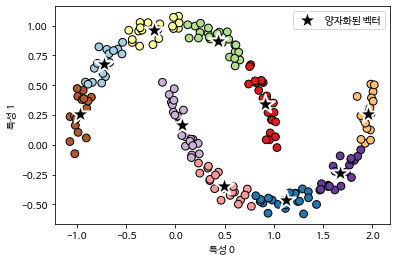

In [11]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, s=60, cmap='Paired', edgecolors='black')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=400, marker='*',
            linewidth=2, c='k', cmap='Paired', edgecolors='w', label="양자화된 벡터")
plt.xlabel('특성 0')
plt.ylabel('특성 1')
plt.legend()

## 벡터양자화를 다른 모델에 적용

* 원래 특성 2개만으로는 불가능했지만, 벡터 양자화로 늘린 10차원 형태를 이용하면 선형 모델을 사용해 두 개의 반달 모양을 구분할 수 있음

### transform 메소드 이용(거리 계산)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

# 각 데이터 포인트에 대한 cluster_centers와의 거리 계산
distance_features_train, distance_features_test = kmeans.transform(X_train), kmeans.transform(X_test)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none').fit(distance_features_train, y_train)

print('훈련 데이터 정확도 :', clf.score(distance_features_train, y_train))
print('테스트 데이터 정확도 :', clf.score(distance_features_test, y_test))

훈련 데이터 정확도 : 1.0
테스트 데이터 정확도 : 1.0


### 원핫 인코딩 이용

In [13]:
# 원핫 인코딩
X_train_pred, X_test_pred = kmeans.predict(X_train), kmeans.predict(X_test)
X_train_vectorized, X_test_vectorized = np.zeros((len(X_train_pred),10)), np.zeros((len(X_test_pred),10))
X_train_vectorized[np.arange(X_train_pred.size),X_train_pred] = 1
X_test_vectorized[np.arange(X_test_pred.size),X_test_pred] = 1

# 선형 분류
clf = LogisticRegression().fit(X_train_vectorized, y_train)
print('훈련 데이터 정확도 :', clf.score(X_train_vectorized, y_train))
print('테스트 데이터 정확도 :', clf.score(X_test_vectorized, y_test))

훈련 데이터 정확도 : 1.0
테스트 데이터 정확도 : 1.0
